# Purpose:
- analyze z-drift with or without motion correction
    - Using hpc (sbatch_omc_zdrift.py)
- Analyze the output data


In [1]:
import numpy as np
from pystackreg import StackReg
from pathlib import Path
from glob import glob
import tifffile
import h5py
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask import delayed, compute
import napari
import cv2
from pprint import pprint
import pandas as pd

# Dev work for finding matched zstack

In [25]:
def rolling_average_zstack(zstack, rolling_window_flank=2):
    new_zstack = np.zeros(zstack.shape)
    for i in range(zstack.shape[0]):
        new_zstack[i] = np.mean(zstack[max(0, i-rolling_window_flank) : min(zstack.shape[0], i+rolling_window_flank), :, :],
                                axis=0)
    return new_zstack


def get_matched_zstack(emf_fn, ops_fn, zstack_dir, num_planes_around=40):
    ''' 
    
    
    Notes
    - Rolling average of z-stacks was not enough.
    '''
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_roll_bottom = np.min(ops['reg_result'][4][0])
    y_roll_top = np.max(ops['reg_result'][4][0])
    x_roll_left = np.max(ops['reg_result'][4][1])
    x_roll_right = np.min(ops['reg_result'][4][1])
    if y_roll_bottom >= 0:
        y_roll_bottom = -1
    if x_roll_right >= 0:
        x_roll_right = -1

    zstack_fn_list = glob(str(zstack_dir /'ophys_experiment_*_local_z_stack.tiff'))
    center_zstacks = []
    for zstack_fn in zstack_fn_list:
        zstack = tifffile.imread(zstack_fn)
        zstack = med_filt_z_stack(zstack)
        new_zstack = rolling_average_zstack(zstack)
        center_ind = int(np.floor(new_zstack.shape[0]/2))
        center_zstack = new_zstack[center_ind - num_planes_around//2 : center_ind + num_planes_around//2+1]
        center_zstack = center_zstack[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]

        center_zstacks.append(center_zstack)
    first_emf = tifffile.imread(emf_fn)[0, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
    # first_emf = tifffile.imread(emf_fn)[0]
    # first_emf = tifffile.imread(emf_fn)[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right].mean(axis=0)

    first_emf_clahe = image_normalization_uint16(first_emf)
    assert first_emf.min() > 0
    valid_pix_threshold = first_emf.min()/10
    num_pix_threshold = first_emf.shape[0] * first_emf.shape[1] / 2

    sr = StackReg(StackReg.AFFINE)
    corrcoef = np.zeros((len(center_zstacks), center_zstacks[0].shape[0]))
    
    best_tmat_array = []
    emf_reg_array = []
    for i, zstack in enumerate(center_zstacks):
        temp_cc = []
        tmat_list = []
        for j, zstack_plane in enumerate(zstack):
            zstack_plane_clahe = image_normalization_uint16(zstack_plane)            
            tmat = sr.register(zstack_plane_clahe, first_emf_clahe)
            emf_reg = sr.transform(first_emf, tmat=tmat)            
            valid_y, valid_x = np.where(emf_reg > valid_pix_threshold)
            if len(valid_y) > num_pix_threshold:
                temp_cc.append(np.corrcoef(zstack_plane.flatten(), emf_reg.flatten())[0,1])
                tmat_list.append(tmat)
            else:
                temp_cc.append(0)
                tmat_list.append(np.eye(3))
        temp_ind = np.argmax(temp_cc)
        best_tmat = tmat_list[temp_ind]
        emf_reg = sr.transform(first_emf, tmat=best_tmat)
        for j, zstack_plane in enumerate(zstack):
            corrcoef[i,j] = np.corrcoef(zstack_plane.flatten(), emf_reg.flatten())[0,1]
        best_tmat_array.append(best_tmat)
        emf_reg_array.append(emf_reg)

    matched_ind = np.argmax(np.mean(corrcoef, axis=1))
    best_tmat_array = np.array(best_tmat_array)
    emf_reg_array = np.array(emf_reg_array)
    return matched_ind, zstack_fn_list, corrcoef, best_tmat_array, emf_reg_array


def med_filt_z_stack(zstack, kernel_size=5):
    """Get z-stack with each plane median-filtered

    Parameters
    ----------
    zstack : np.ndarray
        z-stack to apply median filtering
    kernel_size : int, optional
        kernel size for median filtering, by default 5
        It seems only certain odd numbers work, e.g., 3, 5, 11, ...

    Returns
    -------
    np.ndarray
        median-filtered z-stack
    """
    filtered_z_stack = []
    for image in zstack:
        filtered_z_stack.append(cv2.medianBlur(
            image.astype(np.uint16), kernel_size))
    return np.array(filtered_z_stack)


def image_normalization_uint16(image, im_thresh=0):
    """Normalize 2D image and convert to uint16
    Prevent saturation.

    Args:
        image (np.ndarray): input image (2D)
                            Just works with 3D data as well.
        im_thresh (float, optional): threshold when calculating pixel intensity percentile.
                            0 by default
    Return:
        norm_image (np.ndarray)
    """
    clip_image = np.clip(image, np.percentile(
        image[image > im_thresh], 0.2), np.percentile(image[image > im_thresh], 99.8))
    norm_image = (clip_image - np.amin(clip_image)) / \
        (np.amax(clip_image) - np.amin(clip_image)) * 0.9
    uint16_image = ((norm_image + 0.05) *
                    np.iinfo(np.uint16).max * 0.9).astype(np.uint16)
    return uint16_image

In [ ]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')

emf_fn_list = glob(str(data_dir / '*_nomotioncorrection_timeseries_*_emf.tif'))
zstack_dir = data_dir / 'ophys_session_1364637859'

client = Client()
task = []
tasks = [delayed(get_matched_zstack)(fn, fn[:-7]+'ops.npy', zstack_dir) for fn in emf_fn_list]
results = compute(*tasks, num_workers = 8)
client.close()

matched_zstack_inds = [r[0] for r in results]
assert len(matched_zstack_inds) == len(np.unique(matched_zstack_inds))



## using scanimage header file to match the depth
- Cannot do this

In [5]:
from ScanImageTiffReader import ScanImageTiffReader
import json


def _extract_dict_from_si_string(string):
    """Parse the 'SI' variables from a scanimage metadata string"""

    lines = string.split('\n')
    data_dict = {}
    for line in lines:
        if line.strip():  # Check if the line is not empty
            key, value = line.split(' = ')
            key = key.strip()
            if value.strip() == 'true':
                value = True
            elif value.strip() == 'false':
                value = False
            else:
                value = value.strip().strip("'")  # Remove leading/trailing whitespace and single quotes
            data_dict[key] = value

    json_data = json.dumps(data_dict, indent=2)
    loaded_data_dict = json.loads(json_data)
    return loaded_data_dict


def _str_to_int_list(string):
    return [int(s) for s in string.strip('[]').split()]


def _str_to_bool_list(string):
    return [bool(s) for s in string.strip('[]').split()]

def metadata_from_scanimage_tif(stack_path):
    """Extract metadata from ScanImage tiff stack

    Dev notes:
    Seems awkward to parse this way
    Depends on ScanImageTiffReader

    Parameters
    ----------
    stack_path : str
        Path to tiff stack

    Returns
    -------
    dict
        stack_metadata: important metadata extracted from scanimage tiff header
    dict
        si_metadata: all scanimge metadata. Each value still a string, so convert if needed.
    dict
        roi_groups_dict: 
    """
    with ScanImageTiffReader(str(stack_path)) as reader:
        md_string = reader.metadata()

    # split si & roi groups, prep for seprate parse
    s = md_string.split("\n{")
    rg_str = "{" + s[1]
    si_str = s[0]

    # parse 1: extract keys and values, dump, then load again
    si_metadata = _extract_dict_from_si_string(si_str)
    # parse 2: json loads works hurray
    roi_groups_dict = json.loads(rg_str)

    stack_metadata = {}
    stack_metadata['num_slices'] = int(si_metadata['SI.hStackManager.actualNumSlices'])
    stack_metadata['num_volumes'] = int(si_metadata['SI.hStackManager.actualNumVolumes'])
    stack_metadata['frames_per_slice'] = int(si_metadata['SI.hStackManager.framesPerSlice'])
    stack_metadata['z_steps'] = _str_to_int_list(si_metadata['SI.hStackManager.zs'])
    stack_metadata['actuator'] = si_metadata['SI.hStackManager.stackActuator']
    stack_metadata['num_channels'] = sum(_str_to_bool_list(si_metadata['SI.hPmts.powersOn']))
    stack_metadata['z_step_size'] = int(si_metadata['SI.hStackManager.actualStackZStepSize'])

    return stack_metadata, si_metadata, roi_groups_dict

In [188]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')

si_fn = '240515_721291_global_30min_1366658085_timeseries_00006.tif'
si_fn = data_dir / si_fn
stack_metadata, si_metadata, roi_groups_dict = metadata_from_scanimage_tif(si_fn)

In [7]:
# si_meata and roi_groups_dict saved
# none of them has depth matching metadata

## Too low correlation?

In [3]:
# visual inspection
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')

emf_fn_list = glob(str(data_dir / '*_nomotioncorrection_timeseries_*_emf.tif'))
zstack_dir = data_dir / 'ophys_session_1364637859'

In [31]:
emf_fn = Path(emf_fn_list[0])
fn_base = emf_fn.name.split('.')[0]
zdrift_fn = emf_fn.parent / f'{fn_base}_zdrift.h5'
with h5py.File(zdrift_fn, 'r') as h:
    corrcoef_zstack_finding = h['corrcoef_zstack_finding'][:]
    matched_zstack_fn = Path('/' + h['matched_zstack_fn'][()].decode('utf-8', errors='replace'))
    corrcoef = h['corrcoef'][:]
    tmat = h['tmat'][:]
    print(h.keys())


<KeysViewHDF5 ['corrcoef', 'corrcoef_zstack_finding', 'matched_inds', 'matched_zstack_fn', 'tmat', 'zstack_fn_list']>


In [19]:
matched_zstack_fn

WindowsPath('//allen/programs/mindscope/workgroups/learning/pilots/online_motion_correction/mouse_721291/test_240515_721291/ophys_session_1364637859/ophys_experiment_1364815944_local_z_stack.tiff')

In [20]:
ops_fn = emf_fn.parent / f'{fn_base[:-3]}ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

y_roll_top = np.max(ops['reg_result'][4][0])
y_roll_bottom = np.min(ops['reg_result'][4][0])    
x_roll_left = np.max(ops['reg_result'][4][1])
x_roll_right = np.min(ops['reg_result'][4][1])
if y_roll_bottom >= 0:
    y_roll_bottom = -1
if x_roll_right >= 0:
    x_roll_right = -1


emf = tifffile.imread(emf_fn)[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
zstack = tifffile.imread(matched_zstack_fn)[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
new_zstack = rolling_average_zstack(zstack)

In [21]:
sr = StackReg(StackReg.RIGID_BODY)
emf_reg = np.zeros(emf.shape)
for fi, fov in enumerate(emf):
    emf_reg[fi] = sr.transform(fov, tmat=tmat)

In [24]:
viewer = napari.Viewer()
for fi, fov in enumerate(emf_reg):
    viewer.add_image(fov, name=f'fov {fi}')
viewer.add_image(new_zstack, name='zstack')

<Image layer 'zstack' at 0x20442dec790>

In [41]:
sr = StackReg(StackReg.RIGID_BODY)
valid_pix_threshold = emf.min()/10
num_pix_threshold = emf.shape[1] * emf.shape[2] / 3
tmat_list = []
fov_reg_list = []
for i, fov in enumerate(emf):
    temp_tmat = []
    temp_cc = []
    for j, zplane in enumerate(new_zstack):
        tmat = sr.register(zplane, fov)
        fov_reg = sr.transform(fov, tmat=tmat)
        valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
        if len(valid_y) > num_pix_threshold:
            temp_cc.append(np.corrcoef(zplane[valid_y, valid_x].flatten(),
                                       fov_reg[valid_y, valid_x].flatten())[0,1])
            temp_tmat.append(tmat)
        else:
            temp_cc.append(0)
            temp_tmat.append(np.eye(3))
    temp_ind = np.argmax(temp_cc)
    tmat = temp_tmat[temp_ind]
    tmat_list.append(tmat)
    fov_reg = sr.transform(fov, tmat=tmat)
    fov_reg_list.append(fov_reg)
    valid_y, valid_x = np.where(fov_reg > valid_pix_threshold)
    
    for j, zplane in enumerate(new_zstack):
        corrcoef[i,j] = np.corrcoef(zplane[valid_y, valid_x].flatten(),
                                    fov_reg[valid_y, valid_x].flatten())[0,1]
matched_inds = np.argmax(corrcoef, axis=1)

In [96]:
tiffn = data_dir / '240515_721291_nomotioncorrection_timeseries_30min_01_emf.tif'
emf = tifffile.imread(tiffn)

In [44]:
matched_inds

array([29, 29, 31, 32, 32, 39, 41, 42, 42, 44], dtype=int64)

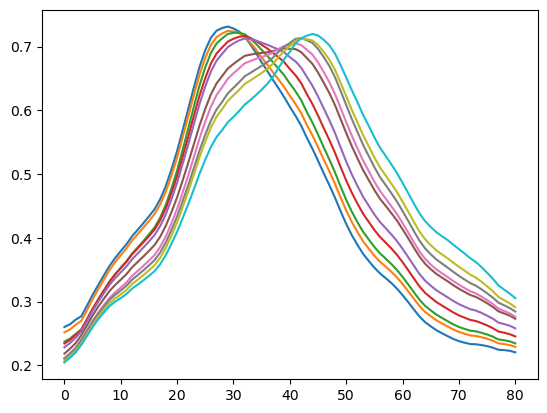

In [46]:
fig, ax = plt.subplots()
for ci, corr in enumerate(corrcoef):
    ax.plot(corr, label=f'epoch {ci}')

In [45]:
[np.max(corr) for corr in corrcoef]

[0.7315111017324019,
 0.7246473655277912,
 0.7217585089465423,
 0.7165068256005256,
 0.7127218905815244,
 0.6973412534352662,
 0.705018104897223,
 0.713271206017413,
 0.7125455092570154,
 0.7198273314268288]

In [ ]:
fov_reg = sr.transform(fov, tmat=tmat)

In [38]:
fov_reg_list = []
for i in range(emf.shape[0]):
    fov = emf[i]
    tmat = tmat_list[i]
    fov_reg = sr.transform(fov, tmat=tmat)
    fov_reg_list.append(fov_reg)

In [43]:
viewer = napari.Viewer()
for i in range(len(fov_reg_list)):
    viewer.add_image(fov_reg_list[i], name=f'epoch {i}')
viewer.add_image(new_zstack, name='zstack')

<Image layer 'zstack' at 0x20459af82e0>

## Another error case in registration 
- Data from 240531

# Analysis

In [47]:
# manual curating of matched z-stack depths using mouse-qc
opid_depths = {'1364815941': 150,
'1364815944': 188,
'1364815946': 110,
'1364815948': 228,
'1364815949': 74,
'1364815951': 268,
'1364815952': 28,
'1364815955': 296}
depth_value_sorted = np.sort(list(opid_depths.values()))

## x-y drift

In [48]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')
ops_fn_list = glob(str(data_dir / '*_timeseries_*_ops.npy'))

fn_list = glob(str(data_dir / '*_timeseries_*.tif'))
emf_fn_list = glob(str(data_dir / '*_timeseries_*_emf.tif'))
fn_list = [fn for fn in fn_list if fn not in emf_fn_list]
fn_base = [Path(fn).name.split('.')[0] for fn in fn_list]
fn_base

['240515_721291_global_30min_1366658085_timeseries_00006',
 '240515_721291_nomotioncorrection_timeseries_30min']

In [49]:
mc_i = 0
nomc_i = 1
omc_fn_list = [fn for fn in emf_fn_list if fn_base[mc_i] in fn]
nomc_fn_list = [fn for fn in emf_fn_list if fn_base[nomc_i] in fn]

In [56]:
ops_fn = ops_fn_list[8]
ops = np.load(ops_fn, allow_pickle=True).item()
print(ops.keys())

dict_keys(['suite2p_version', 'look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'bruker', 'bruker_bidirectional', 'h5py', 'h5py_key', 'nwb_file', 'nwb_driver', 'nwb_series', 'save_path0', 'save_folder', 'subfolders', 'move_bin', 'nplanes', 'nchannels', 'functional_chan', 'tau', 'fs', 'force_sktiff', 'frames_include', 'multiplane_parallel', 'ignore_flyback', 'preclassify', 'save_mat', 'save_NWB', 'combined', 'aspect', 'do_bidiphase', 'bidiphase', 'bidi_corrected', 'do_registration', 'two_step_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'smooth_sigma_time', 'smooth_sigma', 'th_badframes', 'norm_frames', 'force_refImg', 'pad_fft', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', '1Preg', 'spatial_hp_reg', 'pre_smooth', 'spatial_taper', 'roidetect', 'spikedetect', 'sparse_mode', 'spatial_scale', 'connected', 'nbinned', 'max_iterations', 'threshold_scaling', 'max_overlap', 'high_pass'

In [58]:
# find matched split inds between omc and nomc
omc_parent_opid = []
for fn in omc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    omc_parent_opid.append(parent_opid)
nomc_parent_opid = []
for fn in nomc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        nomc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(nomc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    nomc_parent_opid.append(parent_opid)
assert np.array([omc_parent_opid[i]==nomc_parent_opid[i] for i in range(len(omc_parent_opid))]).all()

In [59]:
omc_fn_list

['\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_00_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_01_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_02_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_03_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_721291\\test_240515_721291\\240515_721291_global_30min_1366658085_timeseries_00006_04_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgr

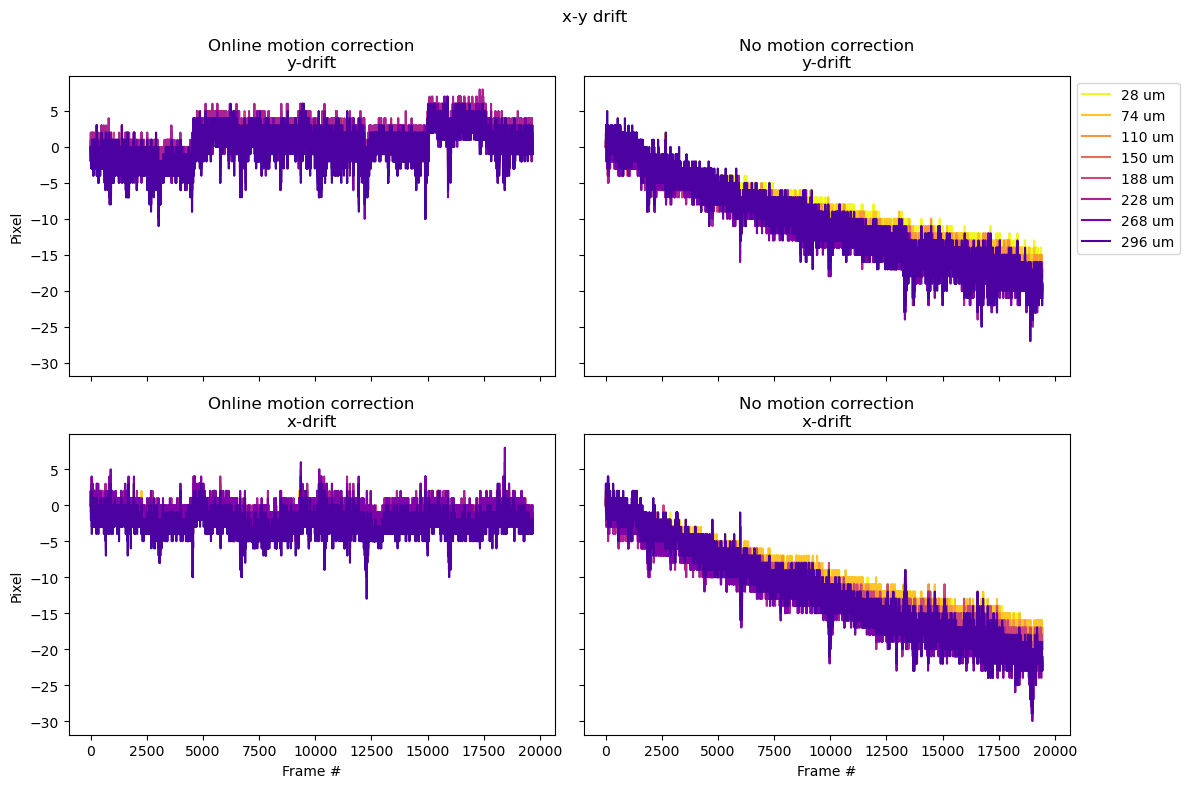

In [67]:
from matplotlib import colormaps as cm
colors = cm.get_cmap('plasma')

fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    ops_fn = fn.split('.')[0][:-3] + 'ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_drift = ops['reg_result'][4][0]
    y_drift = y_drift - y_drift[0]
    x_drift = ops['reg_result'][4][1]
    x_drift = x_drift - x_drift[0]
    cm_val = (8-di) / 8
    ax[0,0].plot(y_drift, color=colors(cm_val), label=f'{depth} um')
    ax[1,0].plot(x_drift, color=colors(cm_val), label=f'{depth} um')

    fn = nomc_fn_list[parent_opid_ind]
    ops_fn = fn.split('.')[0][:-3] + 'ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_drift = ops['reg_result'][4][0]
    y_drift = y_drift - y_drift[0]
    x_drift = ops['reg_result'][4][1]
    x_drift = x_drift - x_drift[0]
    ax[0,1].plot(y_drift, color=colors(cm_val), label=f'{depth} um')
    ax[1,1].plot(x_drift, color=colors(cm_val), label=f'{depth} um')
ax[0,1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[1,0].set_xlabel('Frame #')
ax[1,1].set_xlabel('Frame #')
ax[0,0].set_ylabel('Pixel')
ax[1,0].set_ylabel('Pixel')
ax[0,0].set_title('Online motion correction\ny-drift')
ax[1,0].set_title('Online motion correction\nx-drift')
ax[0,1].set_title('No motion correction\ny-drift')
ax[1,1].set_title('No motion correction\nx-drift')
fig.suptitle('x-y drift')
fig.tight_layout()

## z-drift

In [69]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_721291\test_240515_721291')
fn_list = glob(str(data_dir / '*_timeseries_*.tif'))
emf_fn_list = glob(str(data_dir / '*_timeseries_*_emf.tif'))
fn_list = [fn for fn in fn_list if fn not in emf_fn_list]
fn_base = [Path(fn).name.split('.')[0] for fn in fn_list]
fn_base

['240515_721291_global_30min_1366658085_timeseries_00006',
 '240515_721291_nomotioncorrection_timeseries_30min']

In [70]:
mc_i = 0
nomc_i = 1
omc_fn_list = [fn for fn in emf_fn_list if fn_base[mc_i] in fn]
nomc_fn_list = [fn for fn in emf_fn_list if fn_base[nomc_i] in fn]

In [214]:
# manual curating of matched z-stack depths using mouse-qc
opid_depths = {'1364815941': 150,
'1364815944': 188,
'1364815946': 110,
'1364815948': 228,
'1364815949': 74,
'1364815951': 268,
'1364815952': 28,
'1364815955': 296}
depth_value_sorted = np.sort(list(opid_depths.values()))


In [71]:
# find matched split inds between omc and nomc
omc_parent_opid = []
for fn in omc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    omc_parent_opid.append(parent_opid)
nomc_parent_opid = []
for fn in nomc_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        nomc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(nomc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    nomc_parent_opid.append(parent_opid)
assert np.array([omc_parent_opid[i]==nomc_parent_opid[i] for i in range(len(omc_parent_opid))]).all()

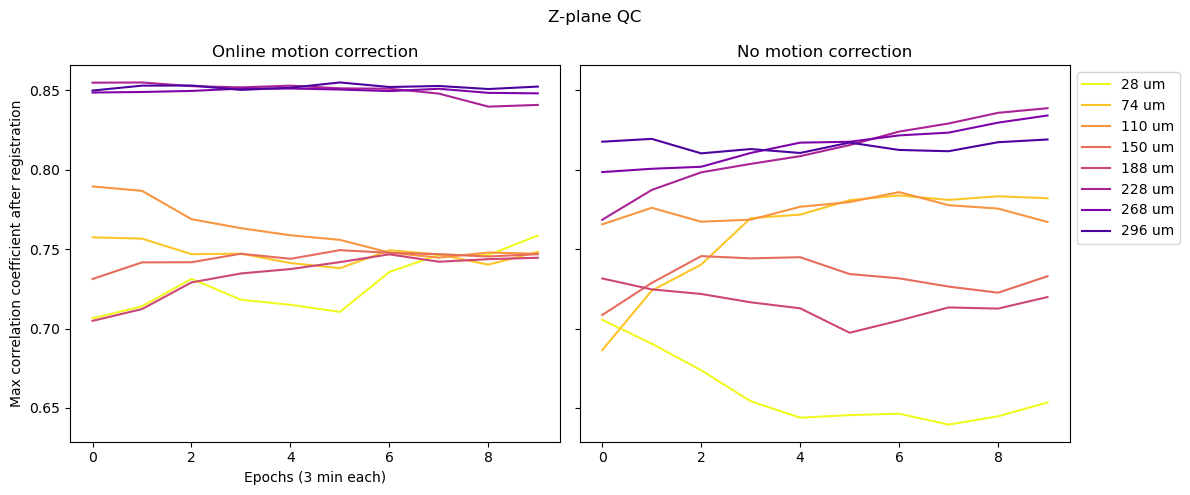

In [84]:
# QC on the registration
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        corrcoef = h['corrcoef'][:]
    max_corr = [cc.max() for cc in corrcoef]
    cm_val = (8-di) / 8
    ax[0].plot(max_corr, label=f'{depth} um', color=colors(cm_val))
    fn = nomc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        corrcoef = h['corrcoef'][:]
    max_corr = [cc.max() for cc in corrcoef]
    assert nomc_matched_zstack_fn == mc_matched_zstack_fn
    ax[1].plot(max_corr, label=f'{depth} um', color=colors(cm_val))
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[0].set_title('Online motion correction')
ax[1].set_title('No motion correction')
ax[0].set_xlabel('Epochs (3 min each)')
ax[0].set_ylabel('Max correlation coefficient after registration')
fig.suptitle('Z-plane QC')
fig.tight_layout()

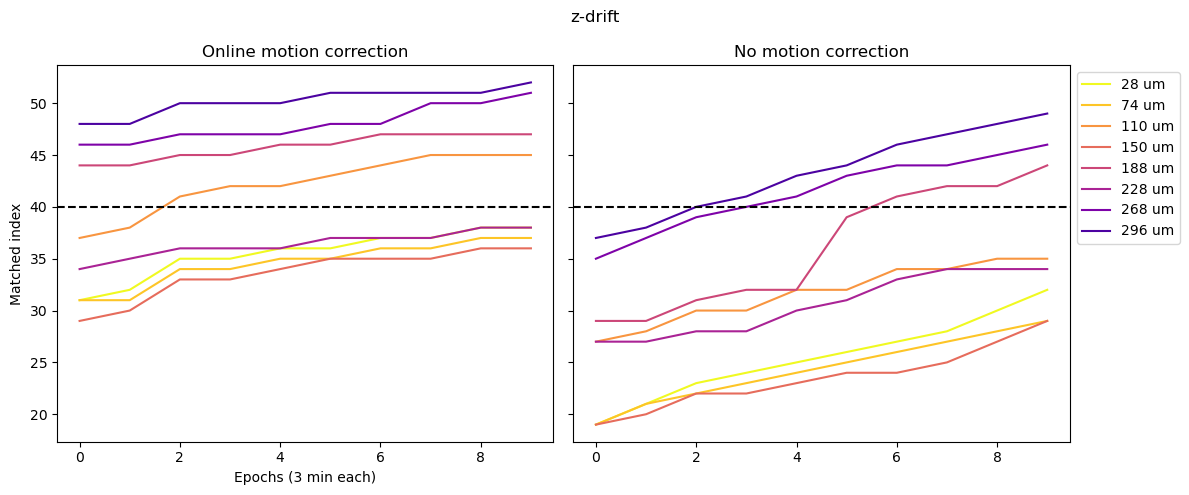

In [73]:
from matplotlib import colormaps as cm
colors = cm.get_cmap('plasma')

fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_inds = h['matched_inds'][:]
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
    parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    cm_val = (8-di) / 8
    ax[0].plot(mc_matched_inds, label=f'{depth} um', color=colors(cm_val))
    fn = nomc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        nomc_matched_inds = h['matched_inds'][:]
        nomc_matched_zstack_fn = h['matched_zstack_fn'][()]
    assert nomc_matched_zstack_fn == mc_matched_zstack_fn
    ax[1].plot(nomc_matched_inds, label=f'{depth} um', color=colors(cm_val))
ax[0].axhline(40, color='k', linestyle='--')
ax[1].axhline(40, color='k', linestyle='--')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[0].set_title('Online motion correction')
ax[1].set_title('No motion correction')
ax[0].set_xlabel('Epochs (3 min each)')
ax[0].set_ylabel('Matched index')
fig.suptitle('z-drift')
fig.tight_layout()

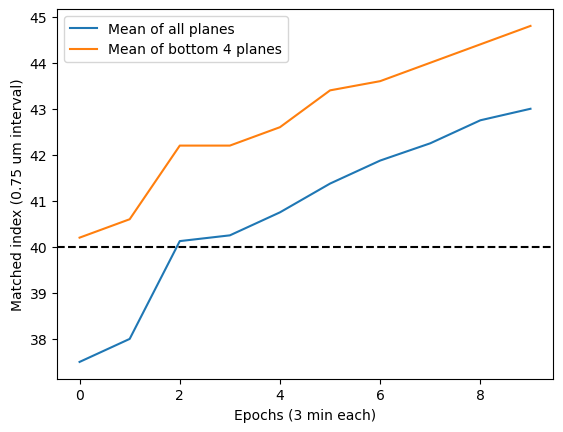

In [76]:
# z-drift from the online motion correction
# Mean of all vs mean of bottom 4
zdrift_omc = []
fig, ax = plt.subplots()
for di, depth in enumerate(depth_value_sorted):
    opid = [key for key, value in opid_depths.items() if value == depth]
    parent_opid_ind = np.where(np.array(omc_parent_opid) == opid)[0][0]
    fn = omc_fn_list[parent_opid_ind]
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:    
        mc_matched_inds = h['matched_inds'][:]
        # mc_matched_zstack_fn = h['matched_zstack_fn'][()]
    # parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    zdrift_omc.append(mc_matched_inds)
zdrift_omc = np.array(zdrift_omc)    
mean_all = zdrift_omc.mean(axis=0)
mean_bottom = zdrift_omc[3:].mean(axis=0)
ax.plot(mean_all, label='Mean of all planes')
ax.plot(mean_bottom, label='Mean of bottom 4 planes')
ax.set_xlabel('Epochs (3 min each)')
ax.set_ylabel('Matched index (0.75 um interval)')
ax.axhline(40, color='k', linestyle='--')
ax.legend()

# Analysis for test 240531
- 2 short sessions with intermittent OMC off
- Analyze csv files as well.

In [85]:
# manual curating of matched z-stack depths using mouse-qc
opid_depths = {'1369640312': 160,
'1369640314': 200,
'1369640315': 120,
'1369640317': 240,
'1369640319': 80,
'1369640321': 280,
'1369640322': 40,
'1369640324': 320}
depth_value_sorted = np.sort(list(opid_depths.values()))


In [31]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_726433\test_240531')
emf_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00002_*_emf.tif'))
# emf_fn_list = glob(str(data_dir / '*_timeseries_*_emf.tif'))

In [182]:
viewer = napari.Viewer()
for fi, fn in enumerate(emf_fn_list):
    emf = tifffile.imread(fn)
    viewer.add_image(emf, name=f'{fi}')

## Paired planes look identical
- It was due to fastzs having the same values

In [14]:
# check tiff header
# tif_fn = data_dir / '1369928218_timeseries_omc_test_00002.tif'
tif_fn = data_dir / 'archive' / '1369928218_timeseries_omc_test_00003.tif'
stack_metadata, si_metadata, roi_groups_dict = metadata_from_scanimage_tif(tif_fn)

## Even so, somehow some planes were not matched well
- Improve zstack matching code (using clahe)
- Asked Arielle how she matches planes
    - She's using platform.json (which is created by WSE)

In [32]:
omc_parent_opid = []
for fn in emf_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    omc_parent_opid.append(parent_opid)

In [33]:
omc_parent_opid

['1369640314',
 '1369640314',
 '1369640317',
 '1369640321',
 '1369640321',
 '1369640321',
 '1369640324',
 '1369640314']

In [140]:
emf_fn

WindowsPath('//allen/programs/mindscope/workgroups/learning/pilots/online_motion_correction/mouse_726433/test_240531/1369928218_timeseries_omc_test_00002_00_emf.tif')

In [22]:
emf_fn = Path(emf_fn_list[5])
fn_base = emf_fn.name.split('.')[0]
ops_fn = emf_fn.parent / f'{fn_base[:-3]}ops.npy'
zstack_dir = data_dir / 'ophys_session_1369518919'
matched_ind, zstack_fn_list, corrcoef, best_tmat_array, emf_reg_array = \
    get_matched_zstack(emf_fn, ops_fn, zstack_dir, num_planes_around=60)

In [23]:
zstack_fn_list[matched_ind]

'\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\ophys_session_1369518919\\ophys_experiment_1369640321_local_z_stack.tiff'

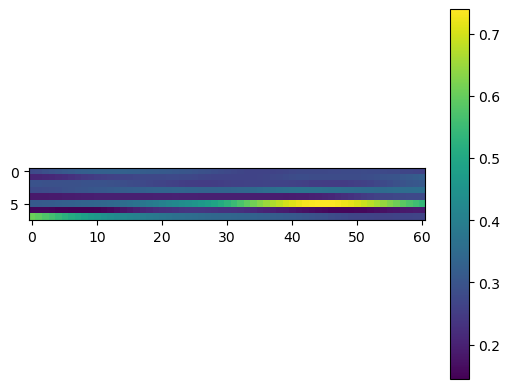

In [24]:
plt.imshow(corrcoef)
plt.colorbar()

In [177]:
emf_fn_list

['\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_00_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_01_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_02_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_03_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_04_emf.tif',
 '\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_05_emf.tif'

In [176]:
ind = 1
viewer = napari.Viewer()

viewer.add_image(emf_reg_array[ind])

ops = np.load(ops_fn, allow_pickle=True).item()
y_roll_bottom = np.min(ops['reg_result'][4][0])
y_roll_top = np.max(ops['reg_result'][4][0])
x_roll_left = np.max(ops['reg_result'][4][1])
x_roll_right = np.min(ops['reg_result'][4][1])
if y_roll_bottom >= 0:
    y_roll_bottom = -1
if x_roll_right >= 0:
    x_roll_right = -1
    
matched_zstack = tifffile.imread(zstack_fn_list[ind])[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]
viewer.add_image(matched_zstack)

<Image layer 'matched_zstack' at 0x2046b81e2e0>

In [90]:
omc_parent_opid

['1369640314',
 '1369640314',
 '1369640317',
 '1369640317',
 '1369640321',
 '1369640317',
 '1369640324',
 '1369640321']

In [44]:
fn

'\\\\allen\\programs\\mindscope\\workgroups\\learning\\pilots\\online_motion_correction\\mouse_726433\\test_240531\\1369928218_timeseries_omc_test_00002_07_emf.tif'

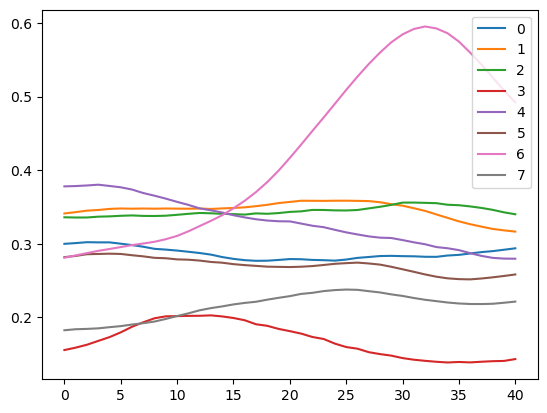

In [56]:
fn = emf_fn_list[1]
h5fn = fn.split('.')[0] + '_zdrift.h5'
ops_fn = fn.split('_emf')[0] + '_ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
y_roll_top = np.max(ops['reg_result'][4][0])
y_roll_bottom = np.min(ops['reg_result'][4][0])    
x_roll_left = np.max(ops['reg_result'][4][1])
x_roll_right = np.min(ops['reg_result'][4][1])
if y_roll_bottom >= 0:
    y_roll_bottom = -1
if x_roll_right >= 0:
    x_roll_right = -1
    
with h5py.File(h5fn, 'r') as h:
    corrcoef_zstack_finding = h['corrcoef_zstack_finding'][:]
    tmat = h['tmat'][:]
    matched_zstack_fn = Path('/' + h['matched_zstack_fn'][()].decode('utf-8', errors='replace'))
    emf_registered = h['emf_registered'][:]
zstack = tifffile.imread(matched_zstack_fn)[:, y_roll_top:y_roll_bottom, x_roll_left:x_roll_right]

fig, ax = plt.subplots()
for ci, cc in enumerate(corrcoef_zstack_finding):
    ax.plot(cc, label=f'{ci}')
ax.legend()

In [57]:
viewer = napari.Viewer()
for emf in emf_registered:
    viewer.add_image(emf)
viewer.add_image(zstack)

<Image layer 'zstack' at 0x2a9cfcb9d60>

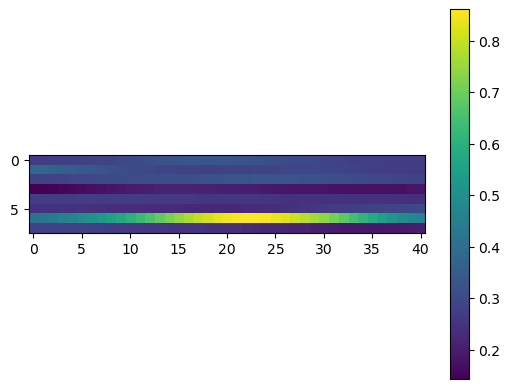

In [ ]:
plt.imshow(corrcoef_zstack_finding)
plt.colorbar()

# Fix registration issue in another notebook
- 240605_zdrift_reg_dev.ipynb

## Back to 240531 analysis
- Both FastZ were targeted to the same depth.
- Just get the results from Ch1 data.
- x-y motion from registration.
- z motion from emf.
- Also check out the logs. Both estimation and correction.

In [2]:
# Results from the previous registration using StackReg
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_726433\test_240531')
emf_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00024_*_emf.tif'))

omc_parent_opid = []
for fn in emf_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:
        mc_matched_zstack_fn = h['matched_zstack_fn'][()]
        parent_opid = Path(mc_matched_zstack_fn.decode('utf-8', errors='replace')).name.split('_')[2]
    omc_parent_opid.append(parent_opid)

pprint(omc_parent_opid)

['1369640314',
 '1369640314',
 '1369640317',
 '1369640317',
 '1369640321',
 '1369640321',
 '1369640324',
 '1369640324']


In [3]:
max_cc_zstack_finding = []
for fn in emf_fn_list:
    h5fn = fn.split('.')[0] + '_zdrift.h5'
    with h5py.File(h5fn, 'r') as h:
        # print(h.keys())
        # corrcoef = h['corrcoef'][:]
        corrcoef_zstack_finding = h['corrcoef_zstack_finding'][:]
    max_cc_zstack_finding.append(corrcoef_zstack_finding.max())
pprint(max_cc_zstack_finding)

[0.8894745097749295,
 0.8609413978040468,
 0.8608845057026778,
 0.7919755776690234,
 0.845273993502077,
 0.7733818425881348,
 0.8293359426184241,
 0.6907266892335641]


In [64]:
emf_inds = [0,2,4,6] # These are the only relevant emf indices


### x-y motion

Text(0.5, 0, 'Frame #')

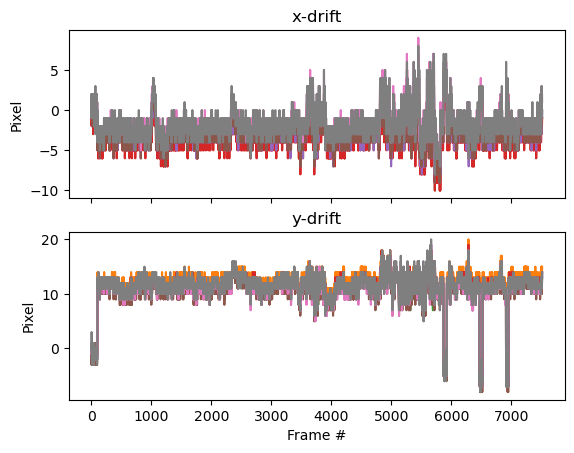

In [122]:
# for trial #2
from matplotlib import colormaps as cm
colors = cm.get_cmap('plasma')

fig, ax = plt.subplots(2,1,sharex=True)
ops_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00024_*_ops.npy'))
for ops_fn in ops_fn_list:    
    ops = np.load(ops_fn, allow_pickle=True).item()
    y_drift = ops['reg_result'][4][0]
    y_drift = y_drift - y_drift[0]
    x_drift = ops['reg_result'][4][1]
    x_drift = x_drift - x_drift[0]
    ax[0].plot(x_drift)
    ax[1].plot(y_drift)
ax[0].set_title('x-drift')
ax[1].set_title('y-drift')
ax[0].set_ylabel('Pixel')
ax[1].set_ylabel('Pixel')
ax[1].set_xlabel('Frame #')

## z motion

Text(0, 0.5, 'Matched index (0.75 um interval)')

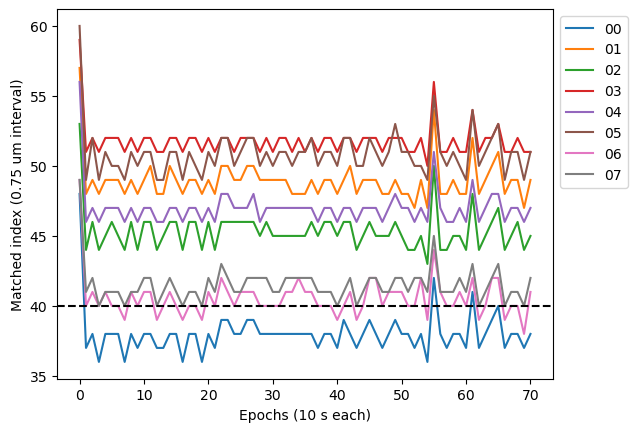

In [123]:
fig, ax = plt.subplots()
zdrift_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00024_*_zdrift.h5'))
for zi in range(len(zdrift_fn_list)):
    zdrift_fn = zdrift_fn_list[zi]
    with h5py.File(zdrift_fn, 'r') as h:
        matched_inds = h['matched_inds'][:]
    ax.plot(matched_inds, label=f'{zi:02}')
ax.axhline(40, color='k', linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('Epochs (10 s each)')
ax.set_ylabel('Matched index (0.75 um interval)')

Text(0, 0.5, 'Matched index')

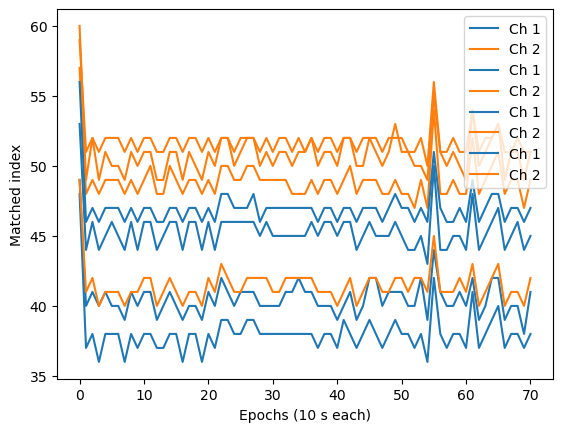

In [14]:
fig, ax = plt.subplots()
zdrift_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00024_*_zdrift.h5'))
for zi in range(len(zdrift_fn_list)):
    zdrift_fn = zdrift_fn_list[zi]
    with h5py.File(zdrift_fn, 'r') as h:
        matched_inds = h['matched_inds'][:]
    if zi % 2 == 0:
        ax.plot(matched_inds, color='C0', label='Ch 1')
    else:
        ax.plot(matched_inds, color='C1', label='Ch 2')
ax.legend()
ax.set_xlabel('Epochs (10 s each)')
ax.set_ylabel('Matched index')

Text(0, 0.5, 'Matched index')

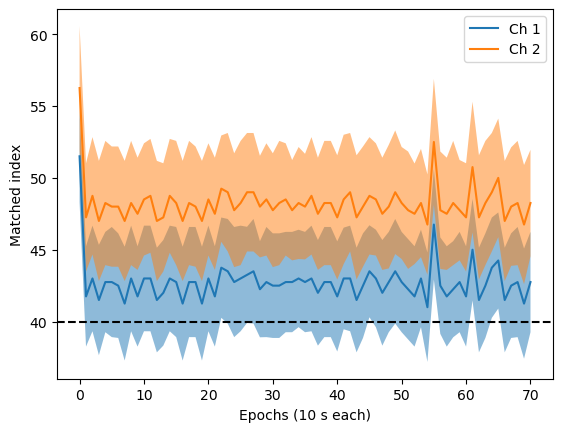

In [17]:

zdrift_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00024_*_zdrift.h5'))
ch1_drift = []
ch2_drift = []
for zi in range(len(zdrift_fn_list)):
    zdrift_fn = zdrift_fn_list[zi]
    with h5py.File(zdrift_fn, 'r') as h:
        matched_inds = h['matched_inds'][:]
    if zi % 2 == 0:
        ch1_drift.append(matched_inds)
    else:
        ch2_drift.append(matched_inds)
fig, ax = plt.subplots()
ax.plot(np.mean(ch1_drift, axis=0), label='Ch 1')
ax.plot(np.mean(ch2_drift, axis=0), label='Ch 2')
ax.fill_between(np.arange(len(ch1_drift[0])), np.mean(ch1_drift, axis=0) - np.std(ch1_drift, axis=0),
                np.mean(ch1_drift, axis=0) + np.std(ch1_drift, axis=0), alpha=0.5)
ax.fill_between(np.arange(len(ch2_drift[0])), np.mean(ch2_drift, axis=0) - np.std(ch2_drift, axis=0),
                np.mean(ch2_drift, axis=0) + np.std(ch2_drift, axis=0), alpha=0.5)
ax.axhline(40, color='k', linestyle='--')
ax.legend()
ax.set_xlabel('Epochs (10 s each)')
ax.set_ylabel('Matched index')

Text(0, 0.5, 'Matched index')

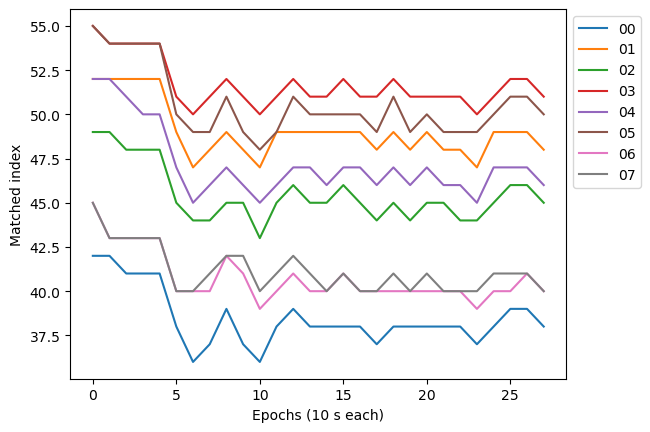

In [21]:
fig, ax = plt.subplots()
zdrift_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00002_*_zdrift.h5'))
for zi in range(len(zdrift_fn_list)):
    zdrift_fn = zdrift_fn_list[zi]
    with h5py.File(zdrift_fn, 'r') as h:
        matched_inds = h['matched_inds'][:]
    ax.plot(matched_inds, label=f'{zi:02}')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('Epochs (10 s each)')
ax.set_ylabel('Matched index')

Text(0, 0.5, 'Matched index')

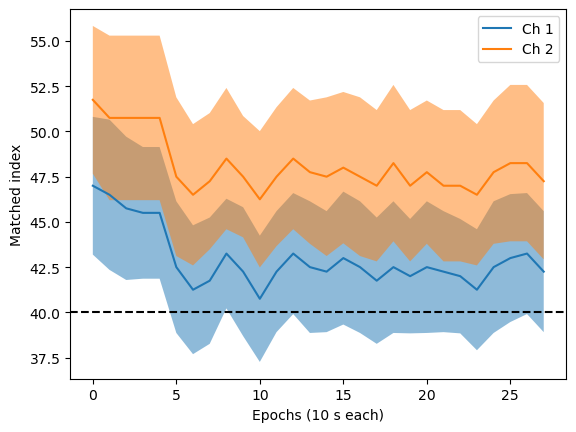

In [22]:

zdrift_fn_list = glob(str(data_dir / '*_timeseries_omc_test_00002_*_zdrift.h5'))
ch1_drift = []
ch2_drift = []
for zi in range(len(zdrift_fn_list)):
    zdrift_fn = zdrift_fn_list[zi]
    with h5py.File(zdrift_fn, 'r') as h:
        matched_inds = h['matched_inds'][:]
    if zi % 2 == 0:
        ch1_drift.append(matched_inds)
    else:
        ch2_drift.append(matched_inds)
fig, ax = plt.subplots()
ax.plot(np.mean(ch1_drift, axis=0), label='Ch 1')
ax.plot(np.mean(ch2_drift, axis=0), label='Ch 2')
ax.fill_between(np.arange(len(ch1_drift[0])), np.mean(ch1_drift, axis=0) - np.std(ch1_drift, axis=0),
                np.mean(ch1_drift, axis=0) + np.std(ch1_drift, axis=0), alpha=0.5)
ax.fill_between(np.arange(len(ch2_drift[0])), np.mean(ch2_drift, axis=0) - np.std(ch2_drift, axis=0),
                np.mean(ch2_drift, axis=0) + np.std(ch2_drift, axis=0), alpha=0.5)
ax.axhline(40, color='k', linestyle='--')
ax.legend()
ax.set_xlabel('Epochs (10 s each)')
ax.set_ylabel('Matched index')

## From the logs

In [51]:

estimation_log_fn = data_dir / '1369928218_timeseries_omc_test_Motion_00024.csv'
estimation_log = pd.read_csv(estimation_log_fn)
correction_log_fn = data_dir / '1369928218_timeseries_omc_test_Motion_Corrected_00024.csv'
correction_log = pd.read_csv(correction_log_fn)

In [36]:
estimation_log.columns

Index(['timestamp', ' frameNumber', ' roiName', ' z', ' drPixel', ' drRef',
       ' confidence', ' userData', 'drPix_y', 'drPix_x', 'drPix_z'],
      dtype='object')

In [90]:
estimation_log['drPix_x'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
estimation_log['drPix_y'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
estimation_log['drPix_z'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
estimation_log['dr_x'] = estimation_log[' drRef'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
estimation_log['dr_y'] = estimation_log[' drRef'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))

In [98]:
estimation_log.apply(lambda x: np.round(x.drPix_x / x.dr_x,8) if x.dr_x != 0 else 0, axis=1).unique()

array([200.95999997,   0.        ])

In [96]:
estimation_log.apply(lambda x: np.round(x.drPix_y / x.dr_y, 8) if x.dr_y != 0 else 0, axis=1).unique()

array([200.95999997,   0.        ])

In [99]:
correction_log['dr_x'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
correction_log['dr_y'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
correction_log['dr_z'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
deg_to_pix = 200.95999997
correction_log['drPix_x'] = correction_log['dr_x'] * deg_to_pix
correction_log['drPix_y'] = correction_log['dr_y'] * deg_to_pix

In [43]:
print(len(estimation_log.timestamp.unique()))
print(len(estimation_log))

10261
10261


In [54]:
estimation_log['timestamp'] 

0          0.000000
1          0.255917
2          0.372242
3          0.395508
4          0.465303
            ...    
10256    698.734144
10257    698.827239
10258    698.850513
10259    698.990155
10260    699.013429
Name: timestamp, Length: 10261, dtype: float64

In [57]:
pd.to_datetime(estimation_log['timestamp'], unit='s')

0       1970-01-01 00:00:00.000000
1       1970-01-01 00:00:00.255917
2       1970-01-01 00:00:00.372242
3       1970-01-01 00:00:00.395508
4       1970-01-01 00:00:00.465303
                   ...            
10256   1970-01-01 00:11:38.734144
10257   1970-01-01 00:11:38.827239
10258   1970-01-01 00:11:38.850513
10259   1970-01-01 00:11:38.990155
10260   1970-01-01 00:11:39.013429
Name: timestamp, Length: 10261, dtype: datetime64[ns]

In [ ]:
# draw rolling average of drPix_y based on timestamps of estimation_
estimation_log['datetime'] = pd.to_datetime(estimation_log['timestamp'], unit='s')
estimation_log.set_index('datetime', inplace=True)
drPix_y = estimation_log['drPix_y']
drPix_y_roll = drPix_y.rolling('10s').mean()

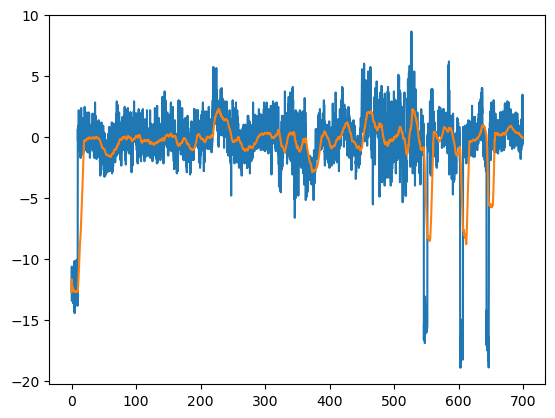

In [101]:

fig, ax = plt.subplots()
ax.plot(estimation_log['timestamp'], drPix_y.values)
ax.plot(estimation_log['timestamp'], drPix_y_roll.values)




Text(0.5, 1.0, 'Correction')

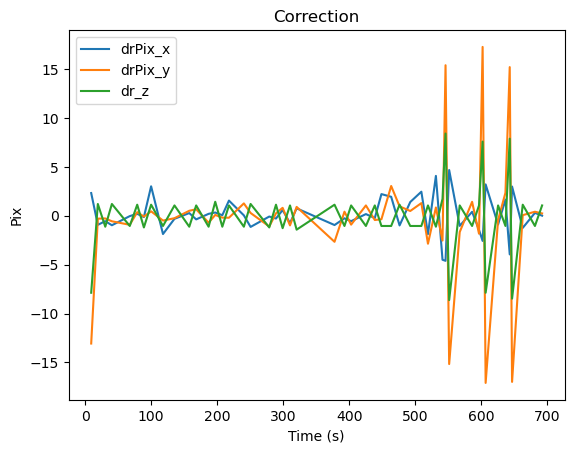

In [120]:
fig, ax = plt.subplots()

correction_log.plot(x='timestamp', y='drPix_x', ax=ax)
correction_log.plot(x='timestamp', y='drPix_y', ax=ax)
correction_log.plot(x='timestamp', y='dr_z', ax=ax)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pix')
ax.set_title('Correction')

In [103]:
correction_log.timestamp.isin(estimation_log.timestamp).all()

True

In [105]:
estimation_log['corrected'] = estimation_log.timestamp.isin(correction_log.timestamp)


,timestamp,frameNumber,roiName,z,drPixel,drRef,confidence,userData,drPix_y,drPix_x,drPix_z,dr_x,dr_y,corrected
datetime,,,,,,,,,,,,,,
1970-01-01 00:00:00.000000,0.000000,1,ROI 1,138.0,[2.72727272727273 -12.7272727272727 -5.863636...,[0.0135712217737929 -0.0633323682776989 -5.86...,[0.0265339426696301 0.0265339426696301 0.0265...,,-12.727273,2.727273,-5.863636,0.013571,-0.063332,False
1970-01-01 00:00:00.255917,0.255917,12,ROI 1,260.0,[-0.181818181818182 -10.6363636363636 -6],[-0.00090474811825203 -0.0529277649177908 -6],[0.00856202188879251 0.00856202188879251 0.00...,,-10.636364,-0.181818,-6.000000,-0.000905,-0.052928,False
1970-01-01 00:00:00.372242,0.372242,17,ROI 1,138.0,[2.90909090909091 -13.4545454545455 -5.522727...,[0.0144759698920449 -0.0669513607507106 -5.52...,[0.0241578929126263 0.0241578929126263 0.0241...,,-13.454545,2.909091,-5.522727,0.014476,-0.066951,False
1970-01-01 00:00:00.395508,0.395508,18,ROI 1,182.0,[2.72727272727273 -12.8181818181818 -10.43181...,[0.0135712217737929 -0.063784742336825 -10.43...,[0.0166495461016893 0.0166495461016893 0.0166...,,-12.818182,2.727273,-10.431818,0.013571,-0.063785,False
1970-01-01 00:00:00.465303,0.465303,21,ROI 1,138.0,[2.27272727272727 -13.1818181818182 -5.931818...,[0.011309351478161 -0.0655942385733308 -5.931...,[0.0239790491759777 0.0239790491759777 0.0239...,,-13.181818,2.272727,-5.931818,0.011309,-0.065594,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:11:38.734144,698.734144,30025,ROI 1,138.0,[3.18181818181818 0 1.43181818181819],[0.0158330920694247 0 1.43181818181819],[0.0248943381011486 0.0248943381011486 0.0248...,,0.000000,3.181818,1.431818,0.015833,0.000000,False
1970-01-01 00:11:38.827239,698.827239,30029,ROI 1,138.0,[1.72727272727273 -0.363636363636364 1.636363...,[0.00859510712340139 -0.00180949623650584 1.6...,[0.0251803826540709 0.0251803826540709 0.0251...,,-0.363636,1.727273,1.636364,0.008595,-0.001809,False
1970-01-01 00:11:38.850513,698.850513,30030,ROI 1,182.0,[2.18181818181818 0 -1.5],[0.0108569774190332 0 -1.5],[0.0164455156773329 0.0164455156773329 0.0164...,,0.000000,2.181818,-1.500000,0.010857,0.000000,False


In [115]:
history_len = 10
rolling_x = []
rolling_y = []
rolling_z = []
for i in range(len(estimation_log)):
    curr_timestamp = estimation_log.iloc[i].timestamp
    min_history_timestamp = curr_timestamp - history_len
    min_history_ind = np.where(estimation_log.timestamp.values > min_history_timestamp)[0][0]
    # max_history_corrected = np.where(estimation_log.corrected.values[:i])[0]
    # if len(max_history_corrected) > 0:
    #     max_history_corrected = max_history_corrected[-1]
    #     if max_history_corrected > min_history_ind:
    #         min_history_ind = max_history_corrected
    rolling_x.append(estimation_log.drPix_x.values[min_history_ind:i].mean())
    rolling_y.append(estimation_log.drPix_y.values[min_history_ind:i].mean())
    rolling_z.append(estimation_log.drPix_z.values[min_history_ind:i].mean())


C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7384\2065691666.py:14: RuntimeWarning: Mean of empty slice.
  rolling_x.append(estimation_log.drPix_x.values[min_history_ind:i].mean())
c:\Users\jinho.kim\Anaconda3\envs\napari-matplotlib\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7384\2065691666.py:15: RuntimeWarning: Mean of empty slice.
  rolling_y.append(estimation_log.drPix_y.values[min_history_ind:i].mean())
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7384\2065691666.py:16: RuntimeWarning: Mean of empty slice.
  rolling_z.append(estimation_log.drPix_z.values[min_history_ind:i].mean())


In [116]:
estimation_log['rolling_x'] = rolling_x
estimation_log['rolling_y'] = rolling_y
estimation_log['rolling_z'] = rolling_z


Text(0.5, 1.0, 'Estimation')

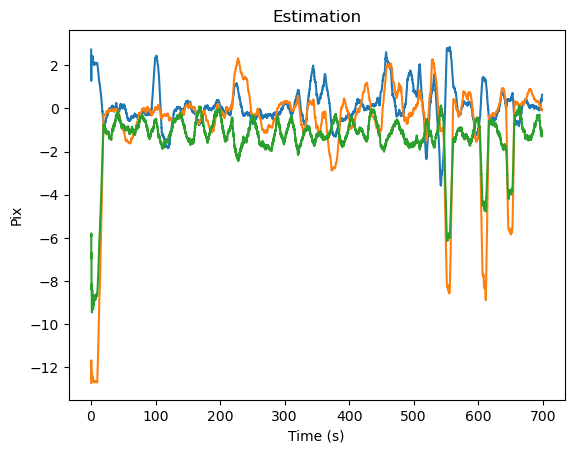

In [119]:
fig, ax = plt.subplots()
ax.plot(estimation_log['timestamp'], estimation_log['rolling_x'], label='x')
ax.plot(estimation_log['timestamp'], estimation_log['rolling_y'], label='y')
ax.plot(estimation_log['timestamp'], estimation_log['rolling_z'], label='z')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pix')
ax.set_title('Estimation')

### Estimation from grand average is different from both registration and correction log
- Try estimating per plane and then averaging
- With per second estimation (for the ease of calculation)

In [124]:
estimation_log.timestamp.max()

699.013429

In [125]:
estimation_log[' z'].unique()

array([138., 260., 182., 224.])

In [127]:
history_len = 10
max_timestamp = round(estimation_log.timestamp.max())
rolling_x = [[], [], [], []]
rolling_y = [[], [], [], []]
rolling_z = [[], [], [], []]
for zi, z in enumerate(estimation_log[' z'].unique()):
    temp_log = estimation_log[estimation_log[' z'] == z]
    temp_timestamp = temp_log.timestamp.values
    for ti in range(max_timestamp):
        curr_timestamp_inds = np.where(temp_timestamp > ti)[0]
        if len(curr_timestamp_inds) > 0:
            curr_timestamp_ind = curr_timestamp_inds[0]
            min_history_timestamp = ti - history_len
            min_history_ind = np.where(temp_timestamp >= min_history_timestamp)[0][0]
            rolling_x[zi].append(temp_log.drPix_x.values[min_history_ind:curr_timestamp_ind].mean())
            rolling_y[zi].append(temp_log.drPix_y.values[min_history_ind:curr_timestamp_ind].mean())
            rolling_z[zi].append(temp_log.drPix_z.values[min_history_ind:curr_timestamp_ind].mean())


C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7384\1534809339.py:15: RuntimeWarning: Mean of empty slice.
  rolling_x[zi].append(temp_log.drPix_x.values[min_history_ind:curr_timestamp_ind].mean())
c:\Users\jinho.kim\Anaconda3\envs\napari-matplotlib\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7384\1534809339.py:16: RuntimeWarning: Mean of empty slice.
  rolling_y[zi].append(temp_log.drPix_y.values[min_history_ind:curr_timestamp_ind].mean())
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7384\1534809339.py:17: RuntimeWarning: Mean of empty slice.
  rolling_z[zi].append(temp_log.drPix_z.values[min_history_ind:curr_timestamp_ind].mean())


Text(0.5, 1.0, 'Estimation')

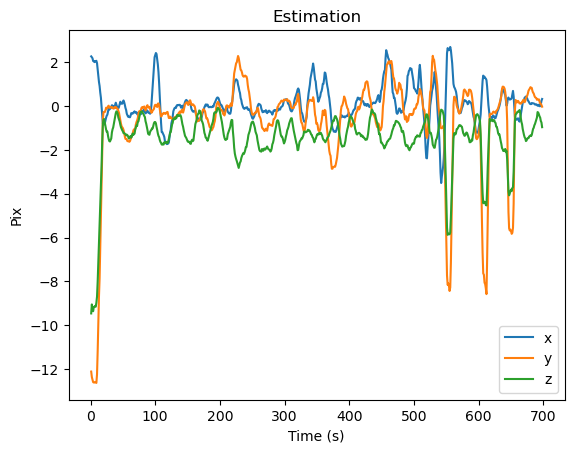

In [133]:
mean_rolling_x = np.array(rolling_x).mean(axis=0)
mean_rolling_y = np.array(rolling_y).mean(axis=0)
mean_rolling_z = np.array(rolling_z).mean(axis=0)
fig, ax = plt.subplots()
ax.plot(mean_rolling_x, label='x')
ax.plot(mean_rolling_y, label='y')
ax.plot(mean_rolling_z, label='z')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pix')
ax.set_title('Estimation')